In [1]:
#import of the libraries used
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, RepeatVector, TimeDistributed,Conv1D, MaxPooling1D, UpSampling1D
from keras.models import Model, load_model
from keras.layers import Input, Dense
from sklearn.preprocessing import StandardScaler
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
import helpers
from PIL import Image

Using TensorFlow backend.


### Loading and preprocessing data

In [2]:
#load the data
initial_data, data = helpers.load_and_preprocess('eighthr.data')

In [3]:
print('Shape of the data {}'.format(data.shape))

Shape of the data (2534, 73)


Split the data into training and testing data. 
We will filter the training data from anomalies, to only train on a normal behavior. 

In [4]:
# split into train and testing data, shuffle parameter is set to false to be able to capture the time relation between input. 
split_train, split_test = train_test_split(data, test_size=0.2, shuffle = False)
X_val_train_large, X_val_test = train_test_split(split_train, test_size = 0.1, shuffle = False)
# filter on anomalies 
X_train = X_val_train_large[X_val_train_large[73] == 0].drop(73,axis = 1)

In [5]:
# standerdize and split the data
scaler = StandardScaler()
scaler.fit(X_train)
#we will standerdize the data using the train set and then using this standardization we will transform the test and validation set
X_train = helpers.prepare_training_data(data = X_train, n_steps=1, scaler=scaler)
X_test, y_test = helpers.prepare_training_data(split_test.iloc[:,:-1],n_steps=1, scaler=scaler), split_test.iloc[:,-1].values
#create a validation set that we will filter from ouliers
y_val_test = X_val_test.iloc[:,-1].values
#take the indices of normal data
indices = np.argwhere(y_val_test == 0).squeeze()
X_val_test.iloc[indices].head()

,1,2,3,4,5,6,7,8,9,10,...,64,65,66,67,68,69,70,71,72,73
1824,3.1,2.8,2.8,2.8,2.8,4.3,5.0,4.8,4.9,5.4,...,0.31122,10.290681,1.101473,5815.90388,10.384499,37.271774,10165.552147,-0.049483,0.00,0.0
1825,1.5,2.4,1.8,2.6,2.7,2.9,2.8,3.3,2.5,3.2,...,0.15000,23.990000,2.060000,5750.00000,21.900000,44.500000,10140.000000,-0.049483,0.00,0.0
1826,4.6,3.8,2.8,2.3,1.7,1.6,1.2,1.7,2.4,2.0,...,0.28000,10.290681,1.101473,5750.00000,7.500000,40.700000,10245.000000,105.000000,0.00,0.0
1827,2.5,2.1,2.0,2.2,2.1,2.4,2.1,2.5,2.8,3.8,...,0.27000,23.910000,-12.490000,5750.00000,-14.700000,6.300000,10335.000000,90.000000,0.00,0.0
1828,1.7,1.5,2.4,2.4,2.9,2.8,2.8,2.7,2.8,3.0,...,0.39000,20.130000,-1.380000,5725.00000,1.600000,25.900000,10310.000000,-25.000000,0.13,0.0


In [6]:
# prepare the training data without anomalies
X_val_train = helpers.prepare_training_data(X_val_test.iloc[indices,:-1],n_steps=1,scaler=scaler)
X_val_test = helpers.prepare_training_data(X_val_test.iloc[:,:-1],n_steps=1,scaler=scaler) 

In [7]:
# create a set of normal data to test how mse is behaving for each model
check_autoencoder = helpers.prepare_training_data(split_test[split_test[73]==0].iloc[:,:-1], n_steps=1,scaler=scaler)

In [8]:
print('X_train shape: {}'.format(X_train.shape))
print('X_test shape: {}'.format(X_test.shape))
print('X_val_train shape: {}'.format(X_val_train.shape))
print('X_val_test shape: {}'.format(X_val_test.shape))

X_train shape: (1693, 1, 71)
X_test shape: (507, 1, 71)
X_val_train shape: (192, 1, 71)
X_val_test shape: (203, 1, 71)


### Different models of autoencoders 

In [9]:
# define parameters: 
INPUT_DIM = X_train.shape[2]
TIMESTEPS = 1
LATENT = 50

#### Regular autoencoder

Since we are training on a large number of epochs for a seek of presentation we will put verbose = 0, but you can change the parameter and set it to 1 in the helpers file and run all the models. 


In [10]:
# fit an regular autoencoder, just one hidden layer with latent dim = 50
# since it's one measure a day the timestep is set to 1

inputs = Input(shape=(TIMESTEPS, INPUT_DIM))
encoder = Dense(50, activation='relu')(inputs)
outputs = Dense((INPUT_DIM))(encoder)

regular = Model(input=inputs, output=outputs)
regular.compile(optimizer='adam', loss='mse',metrics=['accuracy','cosine_proximity'])

regular.summary()
history = helpers.fit_model(autoencoder = regular, X_train=X_train, y_train=X_train, X_val = X_val_train, nb_epoch=200, path='regular_autoencoder.h5')

_________________________________________________________________

C:\Metier\CFAO\WP3661t\python-3.6.6.amd64\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  



Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 71)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 50)             3600      
_________________________________________________________________
dense_2 (Dense)              (None, 1, 71)             3621      
Total params: 7,221
Trainable params: 7,221
Non-trainable params: 0
_________________________________________________________________


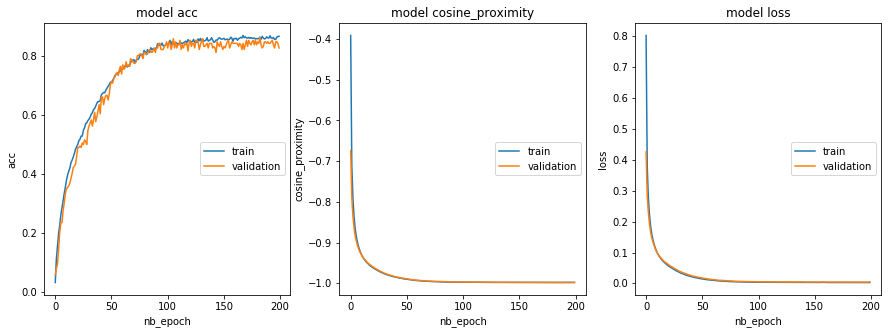

In [11]:
#plot the graphs of how the model behaves over epoch
helpers.plot_graph(history)

In [12]:
print('the mse for the regular autoencoder is: {}'.format(np.mean(helpers.compute_mse(check_autoencoder, regular.predict(check_autoencoder)))))

the mse for the regular autoencoder is: 0.0036584217534772535


#### Denoising autoencoder

In [13]:
# Adding gaussian noise to the data
noise_factor = 0.3
noise = np.random.normal(0, 1, size=X_train.shape)
X_noisy = X_train + noise_factor * noise

In [14]:
inputs = Input(shape=(TIMESTEPS, INPUT_DIM))
encoder = Dense(LATENT, activation='relu')(inputs)
outputs = Dense((INPUT_DIM))(encoder)

denoising = Model(input=inputs, output=outputs)
denoising.compile(optimizer='adam', loss='mse',metrics=['accuracy','cosine_proximity'])

denoising.summary()
history = helpers.fit_model(autoencoder = denoising, X_train=X_noisy, y_train=X_train, X_val = X_val_train, nb_epoch=200, path='denoising_autoencoder.h5')

C:\Metier\CFAO\WP3661t\python-3.6.6.amd64\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1, 71)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1, 50)             3600      
_________________________________________________________________
dense_4 (Dense)              (None, 1, 71)             3621      
Total params: 7,221
Trainable params: 7,221
Non-trainable params: 0
_________________________________________________________________


the mse for the denoising autoencoder is: 0.02017232909448543


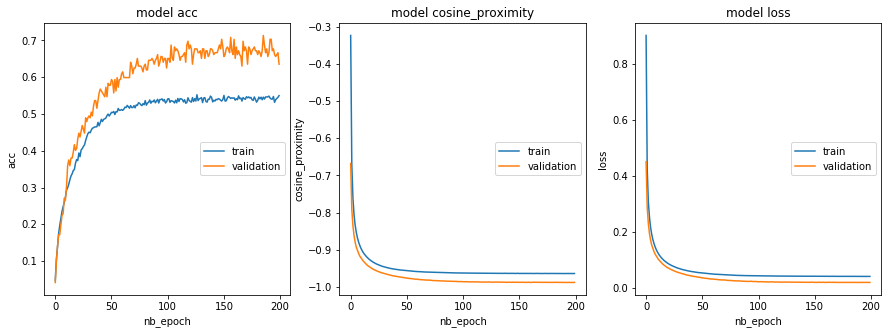

In [15]:
helpers.plot_graph(history)
print('the mse for the denoising autoencoder is: {}'.format(np.mean(helpers.compute_mse(check_autoencoder, denoising.predict(check_autoencoder)))))

#### Sparse autoencoder

In [16]:
# fitting a sparse autoencoder, the only difference here from the regular autoencoder is that the hidden layer is not smaller 
# than the input dimension but thanks to the regularizer will do it's own feature selection, and will set the hidden nodes to 0.
# it's the same logic than the regularizer of a lasso-regression. 

inputs = Input(shape=(TIMESTEPS,INPUT_DIM))
# add a Dense layer with a L1 activity regularizer
encoded = Dense(INPUT_DIM, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(inputs)
decoded = Dense(INPUT_DIM)(encoded)

sparse = Model(inputs, decoded)
sparse.compile(optimizer='adam', loss='mse',metrics=['acc','cosine_proximity'])
sparse.summary()

history = helpers.fit_model(autoencoder = sparse, X_train=X_train, y_train=X_train, X_val = X_val_train, nb_epoch=300, path='sparse_autoencoder.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1, 71)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1, 71)             5112      
_________________________________________________________________
dense_6 (Dense)              (None, 1, 71)             5112      
Total params: 10,224
Trainable params: 10,224
Non-trainable params: 0
_________________________________________________________________


the mse for the sparse autoencoder is: 0.007880917491046725


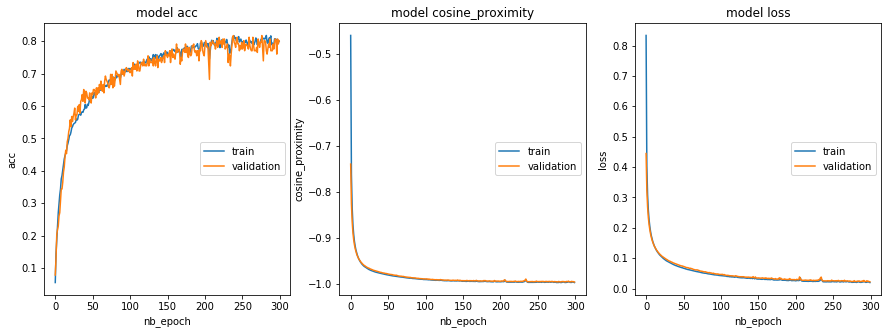

In [17]:
helpers.plot_graph(history)
print('the mse for the sparse autoencoder is: {}'.format(np.mean(helpers.compute_mse(check_autoencoder, sparse.predict(check_autoencoder)))))

#### Sequence_to_sequence autoencoder

In [18]:
inputs = Input(shape=(TIMESTEPS,INPUT_DIM))
encoder = LSTM(LATENT, activation='relu')(inputs)
# define reconstruct decoder
decoder  = RepeatVector(TIMESTEPS)(encoder)
decoder  = TimeDistributed(Dense(INPUT_DIM))(decoder)

lstm = Model(inputs=inputs, outputs=decoder)
lstm.compile(optimizer='adam', loss='mse', 
                    metrics=['acc','cosine_proximity'])

lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1, 71)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                24400     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 50)             0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 71)             3621      
Total params: 28,021
Trainable params: 28,021
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = helpers.fit_model(autoencoder = lstm, X_train=X_train, y_train=X_train, X_val = X_val_train, nb_epoch=250, path='seq2seq_autoencoder.h5')

the mse for the lstm autoencoder is: 0.004252112892632368


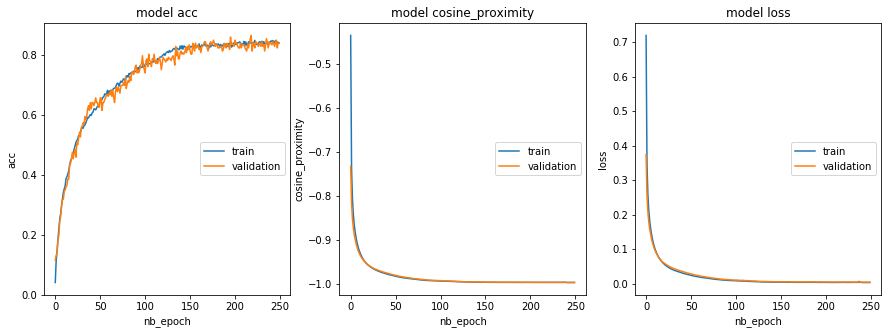

In [20]:
helpers.plot_graph(history)
print('the mse for the lstm autoencoder is: {}'.format(np.mean(helpers.compute_mse(check_autoencoder, lstm.predict(check_autoencoder)))))

#### Deep autoencoder

In [21]:
# fitting a deep autoencoder 
inputs = Input(shape=(TIMESTEPS,INPUT_DIM))
encoder = Dense(LATENT, activation="relu")(inputs)
encoder = Dense(int(LATENT/2), activation="relu")(encoder)

decoder = Dense(int(LATENT/2), activation="relu")(encoder)
decoded = Dense(LATENT, activation="relu")(decoded)
decoded = Dense(INPUT_DIM, activation="relu")(decoder)

deep = Model(inputs, decoded)
deep.compile(optimizer='adam', loss='mse', 
                    metrics=['acc','cosine_proximity'])
deep.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 1, 71)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 1, 50)             3600      
_________________________________________________________________
dense_9 (Dense)              (None, 1, 25)             1275      
_________________________________________________________________
dense_10 (Dense)             (None, 1, 25)             650       
_________________________________________________________________
dense_12 (Dense)             (None, 1, 71)             1846      
Total params: 7,371
Trainable params: 7,371
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = helpers.fit_model(autoencoder = deep, X_train=X_train, y_train=X_train, X_val = X_val_train, nb_epoch=200, path='deep_autoencoder.h5')

the mse for the deep autoencoder is: 0.6245566085172051


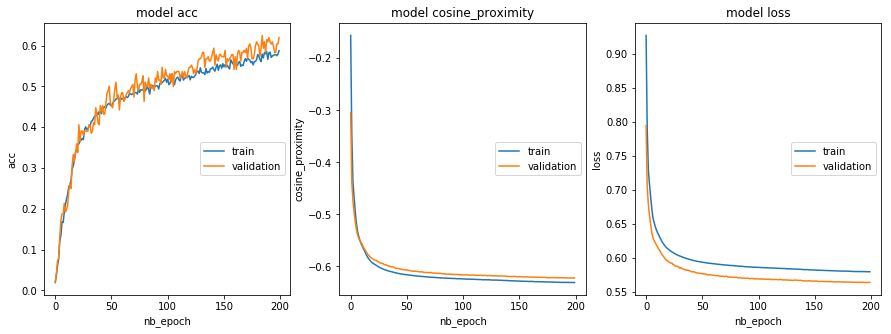

In [23]:
helpers.plot_graph(history)
print('the mse for the deep autoencoder is: {}'.format(np.mean(helpers.compute_mse(check_autoencoder, deep.predict(check_autoencoder)))))

Our best model with the best accuracy is the sequence to sequence model, which seems to be logic in a sense,since our input is a timeserie and the dependencies in time are important, and it's the more suitable model for this task eventhough the other autocoders can achieve more or less good results. 

### Outlier detection 

The autoencoder is trained to give with an accuracy of 85% a good approximation of the input. 

Now the idea is that if we have a rare event, that is not following a certain pattern that our model is used to see, then the reconstruction error on this data point we be higher than the normal range of reconstruction error. 

In [24]:
# calculate the reconstruction error
def compute_mse(X_test,predictions):
    """compute the mean square error."""
    X_test = X_test.reshape((X_test.shape[0],X_test.shape[2]))
    predictions =  predictions.reshape((predictions.shape[0],predictions.shape[2]))
    return np.mean((X_test - predictions)**2,axis=1)

We first need to compute the mse on the X_validation_test in order to select a threshold that gives us the best threshold to avoid being in an overfit situation when we will test on our testing set. 

We will afterwards check the performance of our model using the testing set and appending to it some outliers from those that were drop from the training set. 

in order to select if a point is an outlier or not we will need to select a threshold for the boundaries of the reconstruction error. To do so we will use the intersection point of two metrics defined below. 

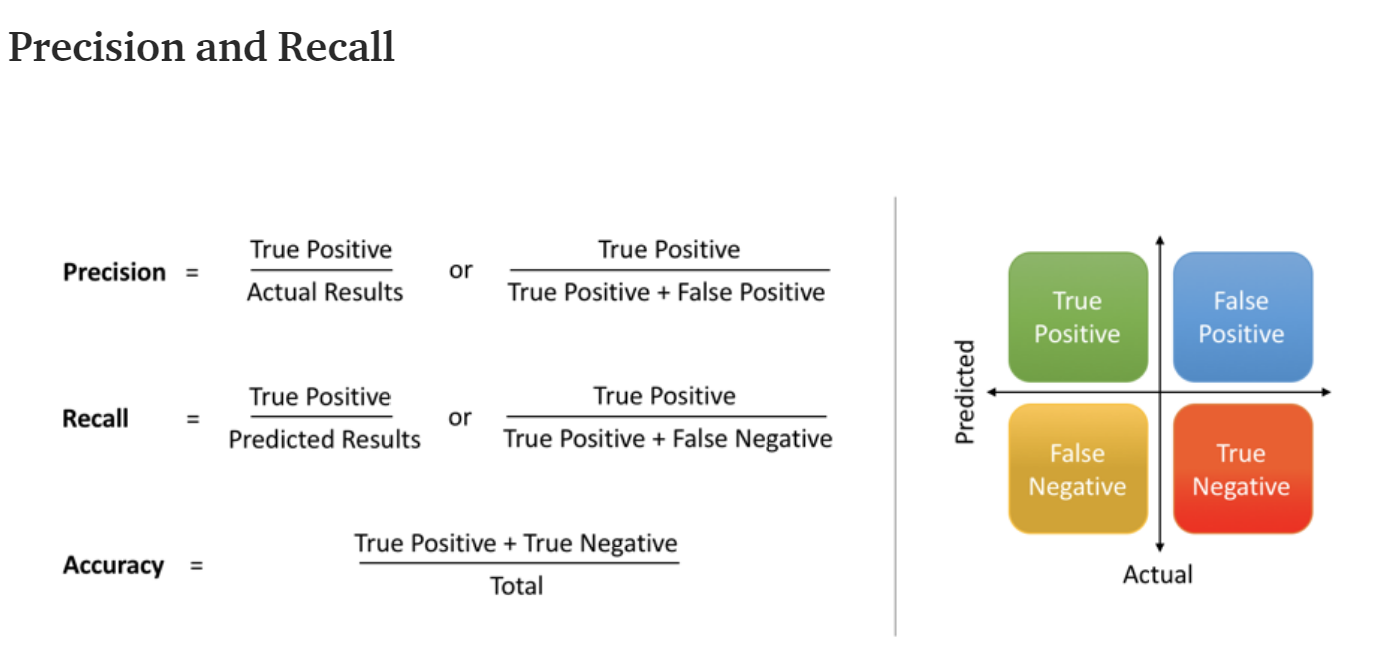

In [25]:
img = Image.open('precision_recall.PNG')
img

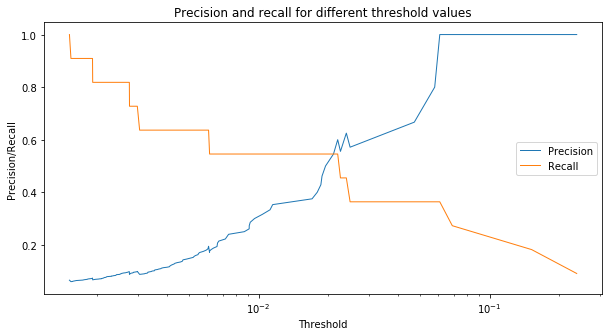

In [26]:
# compute the precision, recall and the thresholds. 
precision, recall, thresholds = precision_recall_curve(y_val_test,compute_mse(X_val_test,lstm.predict(X_val_test)))
helpers.plot_recall_precision(precision, recall, thresholds)

Using the plot, we can see that the intersection point between the recall score and the precision score is about 0.025 so we will select this one. 

In [27]:
#get prediction on the augmented testing
y_pred = helpers.get_predictions(X=X_test, model=lstm, threshold=0.025)

Roc curve using only the test set using different range of thresholds.

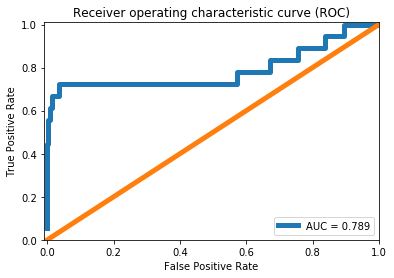

In [28]:
helpers.plot_ROC(y_test,X_test,lstm)

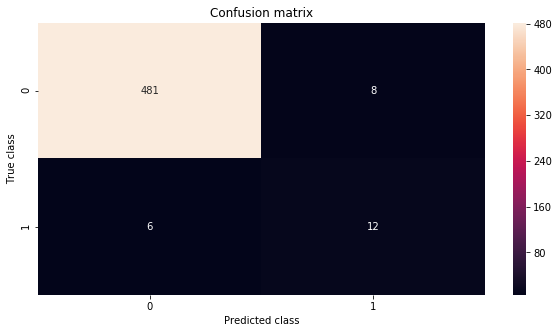

In [29]:
#plot the confusion matrix
helpers.confusion_matrix(y_test,y_pred)


In [30]:
print('the F1 score is {}'.format(metrics.f1_score(y_test,y_pred)))

the F1 score is 0.631578947368421


Roc curve using the test set appended to it the ouliers filtered in the first place


In [31]:
## appending the first outliers that the model haven't seen to have more events to test on
#filter on the 1s in the initial dataset
outliers_training_set = helpers.prepare_training_data(X_val_train_large[X_val_train_large[73] == 1].iloc[:,:-1],1,scaler=scaler)
#concatenate it to the X_test dataset
testing_data = np.concatenate((X_test,outliers_training_set),axis = 0)
#append one to the y_testing vector
y_testing = np.concatenate((y_test, np.array([1 for i in range(len(outliers_training_set))])), axis = 0)

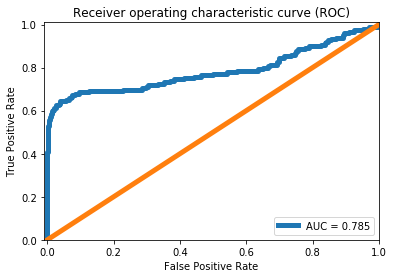

In [32]:
helpers.plot_ROC(y_testing,testing_data,lstm)

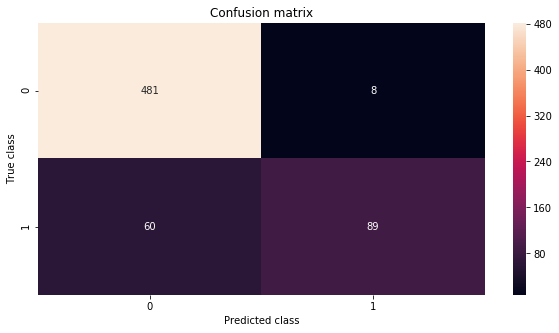

In [33]:
#testing on the augmented testing set and plotting the confusion matrix
y_pred = helpers.get_predictions(testing_data,lstm,0.025)
helpers.confusion_matrix(y_testing,y_pred)

In [34]:
print('The F1 score is {}'.format(metrics.f1_score(y_testing,y_pred)))

The F1 score is 0.7235772357723577


Another intuitive way to set our threshold is to see in the table below where stands the median and the 3-quantile of the reconstruction error on a training set without outliers and do the same on a set containing only outliers and try to select the threshold.
But generally the first method works better, so we will keep our initial threshold from the precision and recall curves. 

In [35]:
df = pd.DataFrame({'val_train_mse':compute_mse(X_val_train,lstm.predict(X_val_train))}).describe()
df

,val_train_mse
count,192.000000
mean,0.004301
std,0.006413
min,0.000512
25%,0.001678
50%,0.002420
75%,0.004268
max,0.057847


### Compare with other methods 

In [36]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor 
from sklearn.cluster import KMeans

In [37]:
#let's train, test split our data again to have it in the right format
X_train, X_test, y_train, y_test = train_test_split(data, data.iloc[:,-1], test_size=0.2, shuffle = False)

### Isolation Forest

In [38]:
#define the model
iso_forest = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.2, \
                        max_features=1, bootstrap=False, n_jobs=-1, verbose=1)

In [39]:
#fit the isolation forest model
iso_forest.fit(X_train[X_train[73]==0].iloc[:,:-1])

[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.2s remaining:    1.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.2s finished


IsolationForest(bootstrap=False, contamination=0.2, max_features=1,
        max_samples='auto', n_estimators=100, n_jobs=-1, random_state=None,
        verbose=1)

In [40]:
#prediction on the test set
y_pred_iso = iso_forest.predict(X_test.iloc[:,:-1])

In [41]:
#change the format of the y vector
y_pred_iso = [1 if i == -1 else 0 for i in y_pred_iso]

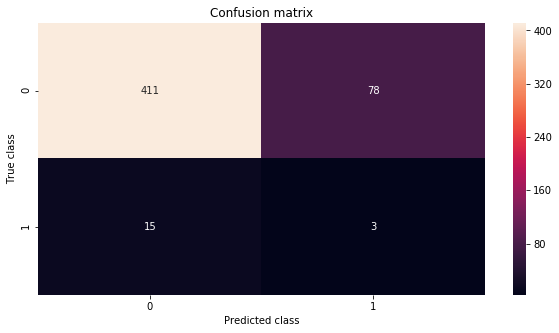

In [42]:
helpers.confusion_matrix(y_test,y_pred_iso)

In [43]:
print('The F1 score is {}'.format(metrics.f1_score(y_test,y_pred_iso)))

The F1 score is 0.06060606060606061


In [44]:
print('The ROC AUC score is {}'.format(metrics.roc_auc_score(y_test,y_pred_iso)))

The ROC AUC score is 0.5035787321063395


### LOF

In [45]:
#fit a localoutfactor model on our data
clf=LocalOutlierFactor(n_neighbors=20, algorithm='auto', leaf_size=40, \
                   metric='minkowski', p=2, metric_params=None, contamination=0.2, n_jobs=-1)

In [46]:
y_pred_clf = clf.fit_predict(data.iloc[:,:-1])
y_pred_clf = [1 if i == -1 else 0 for i in y_pred_clf]

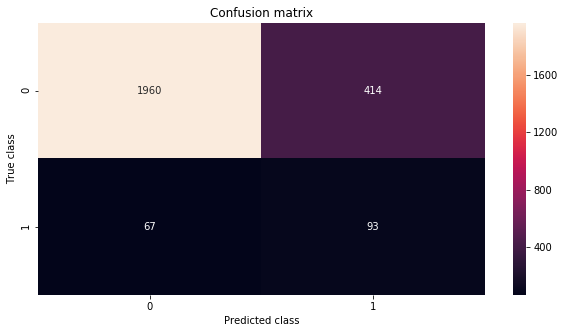

In [47]:
helpers.confusion_matrix(data[73],y_pred_clf)

In [48]:
print('The F1 score is {}'.format(metrics.f1_score(data[73],y_pred_clf)))

The F1 score is 0.2788605697151424


In [49]:
print('The ROC AUC score is {}'.format(metrics.roc_auc_score(data[73],y_pred_clf)))

The ROC AUC score is 0.7034303917438922


### One class SVM 

In [50]:
#fit a one class svm, using different possible kernals
SVM = OneClassSVM(kernel='linear',gamma='auto', coef0=0.0, tol=0.001, nu=0.5, \
                shrinking=True, cache_size=500, verbose=False, max_iter=-1)

SVM.fit(X_train[X_train[73]==0].iloc[:,:-1])

y_pred_osvm = SVM.predict(X_test.iloc[:,:-1])

#Creating class labels based on decision function
y_pred_osvm = [1 if i == -1  else 0 for i in y_pred_osvm]

print('The ROC AUC score for the osvm is {}'.format(metrics.roc_auc_score(y_test,y_pred_osvm)))
print('The F1 score for the osvm is {}'.format(metrics.f1_score(y_test,y_pred_osvm)))

The ROC AUC score for the osvm is 0.4848329925017042
The F1 score for the osvm is 0.06086956521739131


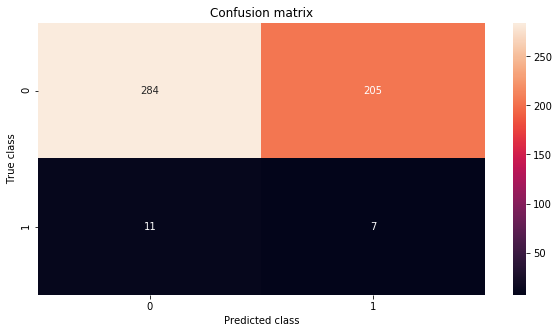

In [51]:
helpers.confusion_matrix(y_test,y_pred_osvm)

### Discussion

For the autoencoders the best one is the LSTM and we explained at the beginning why intuitively we think it's well suited for this data set. 

Regarding the comparison with other algorithms of outlier detection, we can say that the one with the largest f1 and roc curve score is the LOF, but it's performance is still not better than the LSTM autoencoder. We can try to tune more the hyper parameters, try to do a cross validation and select other paramters that can lead to a better performance.

There are more outlier detection algorithms that we can compare our model to such as kmeans or a multivariate gaussian with a normality score.

We can also try to play the Latent variable, and the number of hidden layers to enhance the performance of our model, but the dataset is not that big so increasing the number of hidden layers will make the model too complex for the data and we will be in a situation of overfitting which we had with the deep autoencoder above. 



### References: 

dataset : https://archive.ics.uci.edu/ml/datasets/ozone+level+detection

https://www.kaggle.com/rgaddati/unsupervised-fraud-detection-isolation-forest

https://towardsdatascience.com/extreme-rare-event-classification-using-autoencoders-in-keras-a565b386f098

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

https://blog.keras.io/building-autoencoders-in-keras.html

https://machinelearningmastery.com/lstm-autoencoders/

https://towardsdatascience.com/deep-inside-autoencoders-7e41f319999f